# OCT (Optical Coherence Tomography) Image Classification Project
# Detecting Retinal Diseases using Deep Learning

In [ ]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.regularizers import l2

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


===============================================================
# 1. DATA PREPARATION AND CONFIGURATION
===============================================================


In [ ]:
# Define path for datatset
dataset_path = '/content/drive/MyDrive/OCT2017'

# Access train, test, and validation folders
train_path = f'{dataset_path}/train'
test_path = f'{dataset_path}/test'
val_path = f'{dataset_path}/validation'

In [ ]:
# Define disease categories to classify
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

=============================================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
=============================================================

In [ ]:
# Count number of images per category in each set
def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.exists(category_path):
            category_count[category] = len(os.listdir(category_path))
        else:
            print(f"Warning: {category_path} not found!")
            category_count[category] = 0  # Handle missing folder
    return category_count

# Calculate image distribution across train, validation, and test sets
train_distribution = count_images_in_directory(train_path)
test_distribution = count_images_in_directory(test_path)
val_distribution = count_images_in_directory(val_path)

# Print dataset distributions
print(f"Train Distribution: {train_distribution}")
print(f"Test Distribution: {test_distribution}")
print(f"Validation Distribution: {val_distribution}")

Train Distribution: {'CNV': 37205, 'DME': 11348, 'DRUSEN': 8616, 'NORMAL': 26315}
Test Distribution: {'CNV': 242, 'DME': 242, 'DRUSEN': 242, 'NORMAL': 242}
Validation Distribution: {'CNV': 8, 'DME': 8, 'DRUSEN': 8, 'NORMAL': 8}


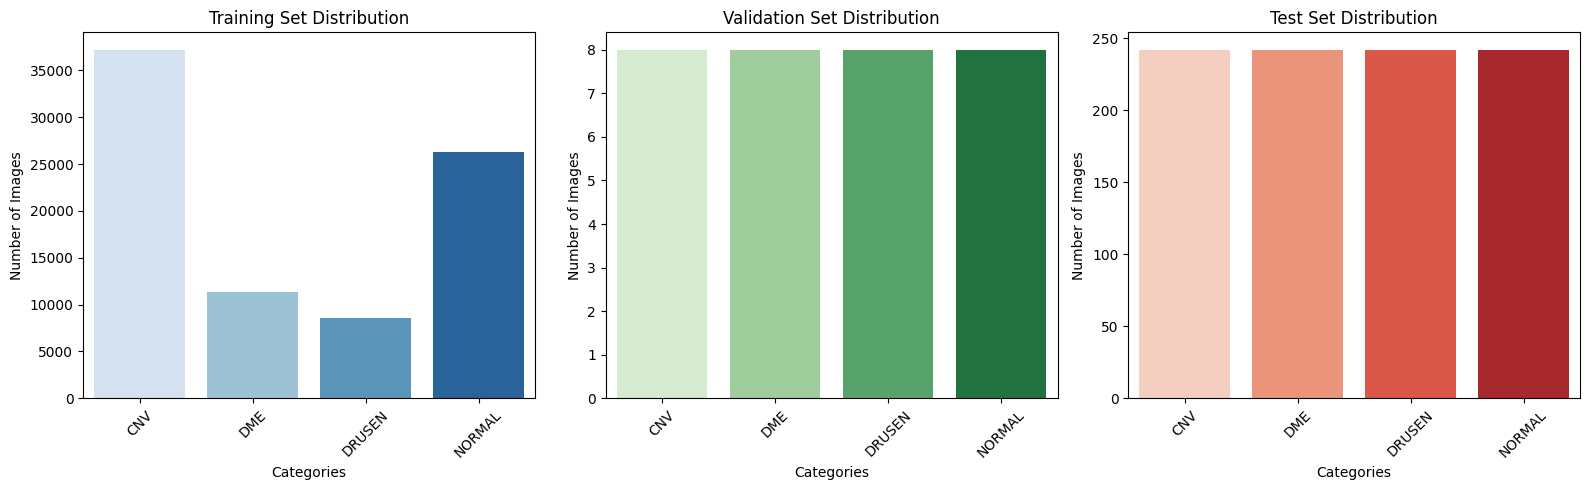

In [ ]:
def plot_class_distribution(train_distribution, val_distribution, test_distribution):
    plt.figure(figsize=(16, 5))

    # Training Set Distribution
    plt.subplot(1, 3, 1)
    train_df = pd.DataFrame.from_dict(train_distribution, orient='index', columns=['count']).reset_index()
    train_df.columns = ['Categories', 'Number of Images']
    sns.barplot(x='Categories', y='Number of Images', data=train_df, palette="Blues", hue='Categories', legend=False)
    plt.title("Training Set Distribution")
    plt.xlabel("Categories")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    # Validation Set Distribution
    plt.subplot(1, 3, 2)
    val_df = pd.DataFrame.from_dict(val_distribution, orient='index', columns=['count']).reset_index()
    val_df.columns = ['Categories', 'Number of Images']
    sns.barplot(x='Categories', y='Number of Images', data=val_df, palette="Greens", hue='Categories', legend=False)
    plt.title("Validation Set Distribution")
    plt.xlabel("Categories")
    plt.xticks(rotation=45)

    # Test Set Distribution
    plt.subplot(1, 3, 3)
    test_df = pd.DataFrame.from_dict(test_distribution, orient='index', columns=['count']).reset_index()
    test_df.columns = ['Categories', 'Number of Images']
    sns.barplot(x='Categories', y='Number of Images', data=test_df, palette="Reds", hue='Categories', legend=False)
    plt.title("Test Set Distribution")
    plt.xlabel("Categories")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_class_distribution(train_distribution, val_distribution, test_distribution)

==================================================================
# 3. DATA PREPROCESSING AND AUGMENTATION
==================================================================

In [ ]:
# Set image dimensions and batch size
img_size = (256, 256)
batch_size = 32

In [ ]:
# Create data generators with augmentation for training
# Augmentation helps improve model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=10,  # Random rotation
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Validation and test data generators (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


==========================================================
# 4. MODEL ARCHITECTURE
==========================================================


In [ ]:
# Define Convolutional Neural Network (CNN) model with L2 Regularization
model = tf.keras.models.Sequential([
    # First Convolutional Layer with L2 Regularization
    tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        input_shape=(256, 256, 3),
        kernel_regularizer=l2(0.001)  # L2 regularization with lambda=0.001
    ),
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.MaxPooling2D(2, 2),

    # Second Convolutional Layer with L2 Regularization
    tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)  # L2 regularization with lambda=0.001
    ),
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.MaxPooling2D(2, 2),

    # Third Convolutional Layer with L2 Regularization
    tf.keras.layers.Conv2D(
        128,
        (3, 3),
        activation='relu',
        kernel_regularizer=l2(0.001)  # L2 regularization with lambda=0.001
    ),
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten and Dense Layers
    tf.keras.layers.Flatten(),

    # Dense layer with L2 Regularization
    tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=l2(0.001)  # L2 regularization with lambda=0.001
    ),
    tf.keras.layers.BatchNormalization(),  # Added batch normalization
    tf.keras.layers.Dropout(0.5),  # Prevent overfitting

    # Output layer
    tf.keras.layers.Dense(
        4,
        activation='softmax',
        kernel_regularizer=l2(0.001)  # L2 regularization with lambda=0.001
    )
])

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,234,758 (50.49 MB)

 Trainable params: 13,234,756 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

========================================================
# 5. MODEL TRAINING
========================================================


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1373s 2s/step - accuracy: 0.2830 - loss: 1.4086 - val_accuracy: 0.5040 - val_loss: 1.1634
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1593s 3s/step - accuracy: 0.5145 - loss: 1.0653 - val_accuracy: 0.5565 - val_loss: 1.0387
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 2072s 3s/step - accuracy: 0.5574 - loss: 1.0047 - val_accuracy: 0.5665 - val_loss: 0.9963
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1892s 3s/step - accuracy: 0.5707 - loss: 0.9635 - val_accuracy: 0.6180 - val_loss: 0.9063
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1866s 3s/step - accuracy: 0.5881 - loss: 0.9461 - val_accuracy: 0.6578 - val_loss: 0.8395
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1353s 2s/step - accuracy: 0.6275 - loss: 0.8899 - val_accuracy: 0.7107 - val_loss: 0.7249
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1316s 2s/step - accuracy: 0.6781 - loss: 0.8059 - val_accuracy: 0.6977 - val_loss: 0.7812
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1242s 2s/step - accuracy: 0.7094 - loss: 0.7597 - 

==============================================================
# 6. VISUALIZE LEARNING CURVES
==============================================================


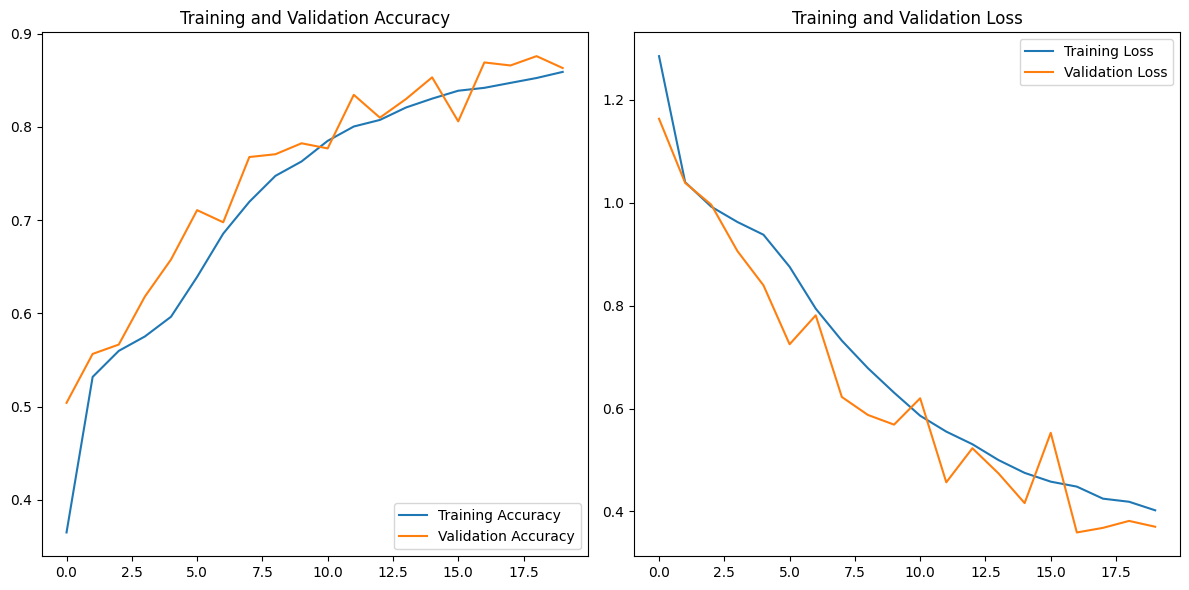

In [ ]:
# Plot training and validation accuracy and loss over epochs.
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Plot learning curves
plot_learning_curves(history)

=======================================================
# 7. MODEL EVALUATION
=======================================================


In [ ]:
# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 477ms/step - accuracy: 0.8549 - loss: 0.3973
Test Accuracy: 86.33%


In [ ]:
# Generate predictions
test_predictions = model.predict(test_generator)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes

125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step


In [ ]:
# Print detailed classification report
class_report = classification_report(
    true_labels,
    test_predictions_labels,
    target_names=categories
)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         CNV       0.87      0.89      0.88      1000
         DME       0.95      0.74      0.83      1000
      DRUSEN       0.90      0.85      0.87      1000
      NORMAL       0.77      0.97      0.86      1000

    accuracy                           0.86      4000
   macro avg       0.87      0.86      0.86      4000
weighted avg       0.87      0.86      0.86      4000



========================================================
# 8. MODEL SAVING
========================================================


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Models/best_cnn_model.h5')

========================================================================
# 9. GRAD-CAM VISUALIZATION AND INTERPRETATION
========================================================================


In [ ]:
# Import necessary libraries
from tensorflow.keras.preprocessing import image
import cv2

==============================================================
## 9.1 IMAGE LOADING AND PREPROCESSING
==============================================================


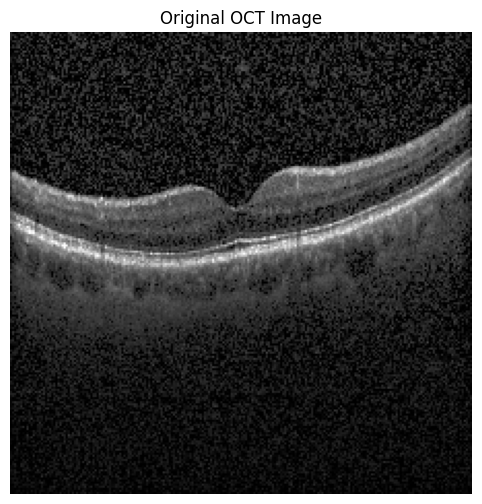

In [ ]:
# Load and preprocess a test image for model prediction.
def load_test_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img, img_array

# Update this path with an actual test image
img_path = "/content/drive/MyDrive/OCT2017/test/NORMAL/NORMAL-1025847-1.jpeg"  # Example image path
original_img, img_array = load_test_image(img_path)

# Visualize original image
plt.figure(figsize=(8, 6))
plt.imshow(original_img)
plt.axis("off")
plt.title("Original OCT Image")
plt.show()

==============================================================
## 9.2 GRAD-CAM IMPLEMENTATION
==============================================================


In [ ]:
# Generate Grad-CAM heatmap to visualize model's decision-making regions.
def grad_cam(model, img_array, layer_name):
    # Create a model that outputs the last conv layer and predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])  # Get the predicted class index
        loss = predictions[:, predicted_class]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]
    # Create weighted heatmap
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap, predicted_class.numpy()

# Function to find the last convolutional layer dynamically
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

last_conv_layer_name = find_last_conv_layer(model)

# Apply Grad-CAM
heatmap, predicted_class = grad_cam(model, img_array, layer_name=last_conv_layer_name)

==============================================================
## 9.3 HEATMAP VISUALIZATION
==============================================================


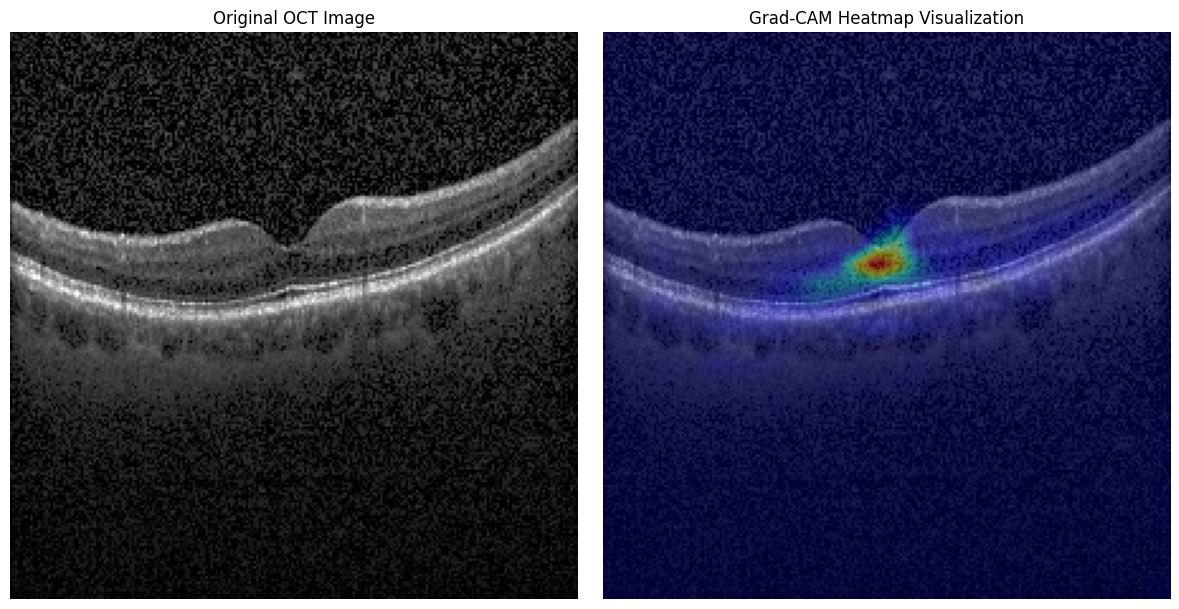

In [ ]:
# Overlay Grad-CAM heatmap on the original image.
def overlay_heatmap(img_array, heatmap, alpha=0.4):
    # Resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)  # Convert to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap

    # Prepare image
    img = np.uint8(255 * img_array[0])  # Convert image to correct format
    overlayed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)  # Merge heatmap with image

    return overlayed_img

# Create the heatmap overlay
overlayed_img = overlay_heatmap(img_array, heatmap)

# Display results
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.axis("off")
plt.title("Original OCT Image")

# Show heatmap overlay
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Heatmap Visualization")

plt.tight_layout()
plt.show()

==============================================================
## 9.4 PREDICTION INTERPRETATION
==============================================================


In [ ]:
# Class mapping for interpretable results
idx_to_class = {
    0: "CNV (Choroidal Neovascularization)",
    1: "DME (Diabetic Macular Edema)",
    2: "Drusen",
    3: "Normal"
}

# Generate predictions
predictions = model.predict(img_array)
predicted_class_idx = np.argmax(predictions)
predicted_class_name = idx_to_class[predicted_class_idx]

# Heatmap color interpretation
heatmap_explanation = (
    "\nRed areas indicate the most critical regions influencing the AI's decision, suggesting high abnormality. "
    "\nOrange and yellow areas represent moderate attention, possibly indicating early signs of disease. "
    "\nBlue and green areas contribute the least to the decision, implying normal or less concerning regions."
)

# Extended explanations for each class
extended_explanations = {
    "CNV (Choroidal Neovascularization)": (
        "The AI highlighted abnormal vascular regions, often associated with excessive blood vessel growth. "
        "These regions may indicate leakage or neovascularization, commonly seen in wet AMD. "
        "The heatmap shows the AI's focus on irregular patterns in the retina, which aligns with CNV characteristics."
        "\n\nNext Step: Confirm with Fluorescein Angiography or OCT Angiography to assess neovascularization."
    ),
    "DME (Diabetic Macular Edema)": (
        "The AI detected fluid accumulation in the macula, emphasizing regions with potential swelling. "
        "The highlighted areas suggest changes in retinal thickness, which are key indicators of macular edema. "
        "The intensity of the heatmap in the central macular zone supports this diagnosis."
        "\n\nNext Step: Confirm with Fundus Photography or Additional OCT scans to evaluate macular thickness."
    ),
    "Drusen": (
        "The AI focused on bright, distinct deposits beneath the retina, which are characteristic of Drusen. "
        "These deposits, often found near the macula, can contribute to vision impairment if they grow larger. "
        "The heatmap highlights these abnormal deposits, reinforcing the likelihood of this condition."
        "\n\nNext Step: Regular OCT scans are advised to monitor Drusen size and density."
    ),
    "Normal": (
        "The AI did not find significant abnormalities in the retinal structure, leading to a normal classification. "
        "The absence of heatmap intensity in critical regions suggests no concerning signs of disease. "
        "A well-defined and evenly structured retina supports this assessment."
        "\n\nNext Step: Routine eye exams are still recommended for continued eye health."
    )
}

# Calculate confidence score
confidence_score = np.max(predictions) * 100

# Retrieve extended explanation
extended_explanation_text = extended_explanations.get(predicted_class_name, "No additional details available.")

# Print comprehensive interpretation
print(f"Predicted Condition: {predicted_class_name} (Severity: {confidence_score:.2f}%)")
print(f"\nInsights:\n{extended_explanation_text}")
print(f"\nHeatmap Interpretation: {heatmap_explanation}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Condition: Normal (Severity: 99.64%)

Insights:
The AI did not find significant abnormalities in the retinal structure, leading to a normal classification. The absence of heatmap intensity in critical regions suggests no concerning signs of disease. A well-defined and evenly structured retina supports this assessment.

Next Step: Routine eye exams are still recommended for continued eye health.

Heatmap Interpretation: 
Red areas indicate the most critical regions influencing the AI's decision, suggesting high abnormality. 
Orange and yellow areas represent moderate attention, possibly indicating early signs of disease. 
Blue and green areas contribute the least to the decision, implying normal or less concerning regions.
